In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pathlib 
import cv2  
import os

from tensorflow.keras import layers
from tensorflow.keras.layers import Input  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.img import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation , RandomZoom, RandomContrast,RandomTranslation,RandomBrightness
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [23]:
# this is the data normailzation and the data trainformation part

In [ ]:
img_folder = "data_full" 


IMG_SIZE = 256 
NUM_CLASSES = 5 


def resize_with_padding(img, target_size=(IMG_SIZE, IMG_SIZE), color=(0, 0, 0)):
    old = img.shape[:2]  # (height, width)

    # here i do some calculations of ration that is needed for the resizement
    ratio = min(target_size[0] / old[0], target_size[1] / old[1])
    new_size = (int(old[1] * ratio), int(old[0] * ratio))
    resized_img = cv2.resize(img, new_size)

    #cacluate the size of the padding that is needed to do
    delw = target_size[1] - new_size[0]
    delh = target_size[0] - new_size[1]
    top, bottom = delh // 2, delh - (delh // 2)
    left, right = delw // 2, delw - (delw // 2)
    #here i use the open cv to put the padding 
    padded_img = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return padded_img


imgs = []
labels = []


for labelDict in os.listdir(img_folder):
    lab_path = os.path.join(img_folder, labelDict)
    if not os.path.isdir(lab_path) or not labelDict.isdigit():
        continue
    label = int(labelDict) 
    
    
    for img_name in os.listdir(lab_path):
        img_path = os.path.join(lab_path, img_name)

        img = cv2.imread(img_path)
        
        if img is None:
            continue  

        img = resize_with_padding(img, target_size=(IMG_SIZE, IMG_SIZE))
        img = img.astype("float") / 255.0
        img = img_to_array(img)
        
       
        imgs.append(img)
        labels.append(label)

labels = np.array(labels)
labels = to_categorical(labels, num_classes=NUM_CLASSES)
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.2, random_state=0, shuffle=True)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)


Training data shape: (440, 256, 256, 3)
Testing data shape: (111, 256, 256, 3)
Training labels shape: (440, 5)
Testing labels shape: (111, 5)


In [26]:
# this is checking that the data pipline is woring fine

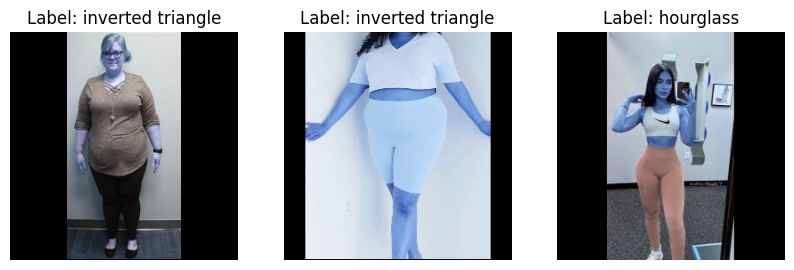

In [ ]:
def show_imgs_with_labels(imgs, labels, label_dict, num_imgs=5):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(range(len(imgs)), num_imgs, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(1, num_imgs, i + 1)
        img = imgs[idx]
        label = np.argmax(labels[idx])  
        plt.imshow(img)
        plt.title(f"Label: {label_dict[label]}")
        plt.axis('off') 
    plt.show()
label_dict = {0: 'pear', 1: 'inverted triangle', 2: 'hourglass', 4: 'banana', 5: 'apple'}  
show_imgs_with_labels(X_train, y_train, label_dict, num_imgs=3)

In [28]:
#this is the model that gives me the best accuraye

In [ ]:
input_shape = (256, 256, 3)
num_classes = 5

data_augmentation = Sequential([
    # RandomFlip("horizontal_and_vertical"),
    # RandomRotation(0.2),
    # RandomZoom(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2)
])

base_model = InceptionV3(weights='imgnet', include_top=False, input_shape=input_shape)

# here added some layers to the base model to make it more covergin toward the given data set later i will unfizer the som upper layers to train

# x = data_augmentation(base_model.input)  # Apply data augmentation to the input
x = base_model.output  
x = GlobalAveragePooling2D()(x)
# x= Conv2D(512, activation='relu')(x)
# x= MaxPooling2D((2,2))(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

#here i unfeerze the 60 upper layer to train according to the data set 
for layer in base_model.layers[-60:]:
    layer.trainable = True

history1 = model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2122 - loss: 3.8720 - val_accuracy: 0.4505 - val_loss: 1.3294
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5114 - loss: 1.2923 - val_accuracy: 0.5495 - val_loss: 1.2249
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6166 - loss: 1.0206 - val_accuracy: 0.6126 - val_loss: 1.0519
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7538 - loss: 0.7279 - val_accuracy: 0.6306 - val_loss: 0.9721
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8142 - loss: 0.5725 - val_accuracy: 0.6306 - val_loss: 1.1478
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7905 - loss: 0.5661 - val_accuracy: 0.6126 - val_loss: 0.9628
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8625 - loss: 0.4376 - val_accuracy: 0.6847 - val_loss: 0.9969
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8857 - loss: 0.3768 - val_accuracy: 0.6757 - val_loss:

In [30]:
#model checking final time

In [31]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation accuracy after fine-tuning: {accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 722ms/step - accuracy: 0.7201 - loss: 1.0608
Validation accuracy after fine-tuning: 71.17%


In [32]:
# plot some graph and stats


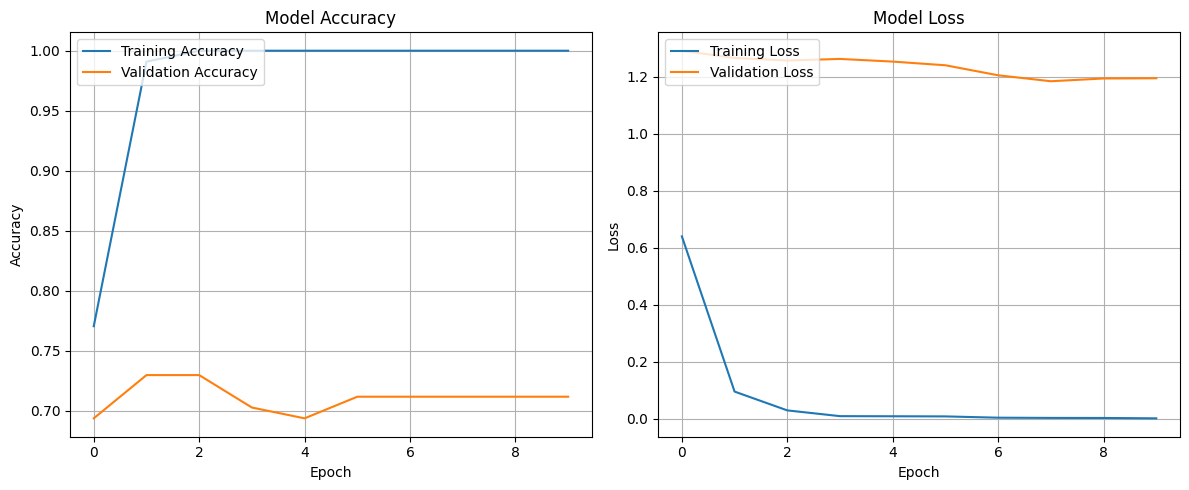

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function with your history object
plot_training_history(history)

In [34]:
# the class wuise result

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  


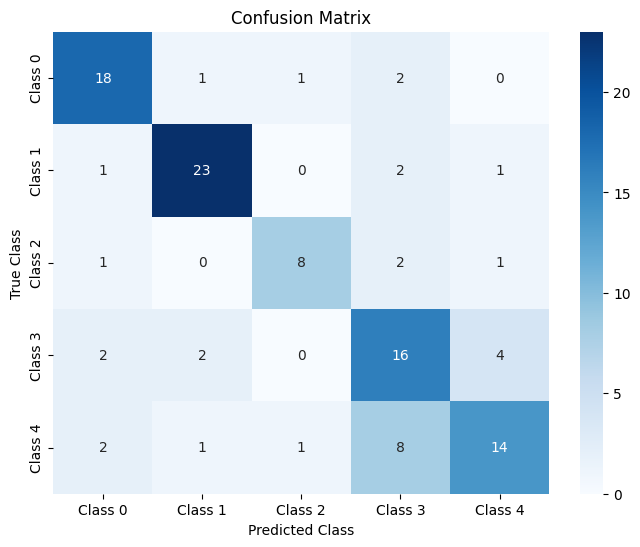

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.75      0.82      0.78        22
     Class 1       0.85      0.85      0.85        27
     Class 2       0.80      0.67      0.73        12
     Class 3       0.53      0.67      0.59        24
     Class 4       0.70      0.54      0.61        26

    accuracy                           0.71       111
   macro avg       0.73      0.71      0.71       111
weighted avg       0.72      0.71      0.71       111



In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = np.argmax(y_test, axis=1)          

# Class names (replace with actual class names if available)
class_names = [f"Class {i}" for i in range(NUM_CLASSES)]

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix for visual inspection
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# 2. Classification Report
# This provides precision, recall, F1-score, and support for each class
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [47]:
# now finally makeing the standalone file in h5 flromat

In [ ]:
model.save('model.h5')
